<a href="https://colab.research.google.com/github/zhouchun0105/Bitcoin-Price-and-Movement-Prediction/blob/main/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import os
from google.colab import drive 
import tensorflow as tf
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [18]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

In [19]:
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(30, 19)))
model.add(Dropout(0.35))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(1))
# model.add(Dense(output_dim=1))
model.compile(optimizer='adam', loss='mse')

In [20]:
checkpoint_path = 'drive/MyDrive/checkpoint1/'
model.load_weights(checkpoint_path)

In [21]:
df = pd.read_csv('drive/MyDrive/bitcoin.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp')
df.columns = ["Open", "High", "Low","Close", "Volume_BTC", "Volume_Currency", "Weighted_Price"]
df.dropna(inplace=True)
df.head(10)
df["Price"] = df[["Open","High","Low","Close"]].mean(axis=1)
df["Return"] = df["Price"].diff()
df["Percentage_Return"] = ((df["Return"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
df["Volume_diff"] = df["Volume_Currency"].diff()
df["Percentage_Volume"] = ((df["Volume_diff"].shift(periods=-1))/ (df["Price"])).shift(periods=1)
low, high = 0.01, 0.99
selected_columns = ["Percentage_Return", "Percentage_Volume"]

quant_df = df[selected_columns].quantile([low, high])

for col in selected_columns:
    df.drop(df[df[col] <= quant_df.loc[low, col]].index, axis=0, inplace=True)
    df.drop(df[df[col] >= quant_df.loc[high, col]].index, axis=0, inplace=True)

stamp1 = pd.Timestamp(2014,6,1)
df = df[df.index>stamp1]

df_t = df[["Volume_Currency", "Weighted_Price"]].copy(deep=True)
times = [2, 120, 240, 600, 1440, 4320, 7200, 14400, 28800]
for col in df_t.columns:
    for t in times:
        df_t[col+'_ratio_'+str(t)] = df_t[col]/df_t[col].rolling(window=t).mean()
df_t.dropna(inplace=True)
df_t

,Volume_Currency,Weighted_Price,Volume_Currency_ratio_2,Volume_Currency_ratio_120,Volume_Currency_ratio_240,Volume_Currency_ratio_600,Volume_Currency_ratio_1440,Volume_Currency_ratio_4320,Volume_Currency_ratio_7200,Volume_Currency_ratio_14400,Volume_Currency_ratio_28800,Weighted_Price_ratio_2,Weighted_Price_ratio_120,Weighted_Price_ratio_240,Weighted_Price_ratio_600,Weighted_Price_ratio_1440,Weighted_Price_ratio_4320,Weighted_Price_ratio_7200,Weighted_Price_ratio_14400,Weighted_Price_ratio_28800
Timestamp,,,,,,,,,,,,,,,,,,,,
2014-07-01 13:20:00,149.643129,652.755990,0.494116,0.040897,0.049898,0.040948,0.035313,0.045747,0.049884,0.050734,0.038701,1.000955,1.005684,1.008167,1.010230,1.025384,1.075811,1.098577,1.097148,1.061968
2014-07-01 13:21:00,2037.418383,653.018712,1.863156,0.555999,0.677806,0.557247,0.480772,0.623049,0.679202,0.690723,0.526918,1.000201,1.005959,1.008528,1.010613,1.025769,1.076210,1.099002,1.097577,1.062393
2014-07-01 13:23:00,1677.587661,653.764882,0.903141,0.456137,0.556909,0.458482,0.396185,0.513006,0.559222,0.568723,0.433983,1.000571,1.006984,1.009636,1.011743,1.026914,1.077405,1.100241,1.098819,1.063606
2014-07-01 13:24:00,13034.225000,651.711250,1.771940,3.473215,4.262214,3.546248,3.071833,3.982491,4.343742,4.417423,3.371495,0.998427,1.003695,1.006434,1.008546,1.023664,1.073986,1.096769,1.095355,1.060263
2014-07-01 13:25:00,117.270000,651.500000,0.017834,0.032981,0.038602,0.031936,0.027641,0.035834,0.039081,0.039744,0.030334,0.999838,1.003231,1.006079,1.008200,1.023307,1.073604,1.096398,1.094988,1.059918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:56:00,81259.372187,58692.753339,0.708872,1.198122,1.001461,0.738670,0.588387,0.567097,0.570214,0.463320,0.421717,0.999666,0.999355,0.999584,0.998660,1.006009,1.029231,1.050250,1.056144,1.036530
2021-03-30 23:57:00,428158.146640,58693.226508,1.680971,6.051692,5.232474,3.871621,3.096415,2.986077,3.003437,2.440925,2.221882,1.000004,0.999378,0.999611,0.998673,1.006005,1.029228,1.050240,1.056152,1.036537
2021-03-30 23:58:00,100117.070370,58696.198496,0.379034,1.398912,1.226897,0.908864,0.723793,0.698267,0.702565,0.570747,0.519555,1.000025,0.999441,0.999682,0.998728,1.006043,1.029270,1.050275,1.056206,1.036588


In [22]:
columns = df_t.columns.tolist()
columns = columns[:11] + columns[12:] + [columns[11]]
df_t = df_t[columns]
df_t

,Volume_Currency,Weighted_Price,Volume_Currency_ratio_2,Volume_Currency_ratio_120,Volume_Currency_ratio_240,Volume_Currency_ratio_600,Volume_Currency_ratio_1440,Volume_Currency_ratio_4320,Volume_Currency_ratio_7200,Volume_Currency_ratio_14400,Volume_Currency_ratio_28800,Weighted_Price_ratio_120,Weighted_Price_ratio_240,Weighted_Price_ratio_600,Weighted_Price_ratio_1440,Weighted_Price_ratio_4320,Weighted_Price_ratio_7200,Weighted_Price_ratio_14400,Weighted_Price_ratio_28800,Weighted_Price_ratio_2
Timestamp,,,,,,,,,,,,,,,,,,,,
2014-07-01 13:20:00,149.643129,652.755990,0.494116,0.040897,0.049898,0.040948,0.035313,0.045747,0.049884,0.050734,0.038701,1.005684,1.008167,1.010230,1.025384,1.075811,1.098577,1.097148,1.061968,1.000955
2014-07-01 13:21:00,2037.418383,653.018712,1.863156,0.555999,0.677806,0.557247,0.480772,0.623049,0.679202,0.690723,0.526918,1.005959,1.008528,1.010613,1.025769,1.076210,1.099002,1.097577,1.062393,1.000201
2014-07-01 13:23:00,1677.587661,653.764882,0.903141,0.456137,0.556909,0.458482,0.396185,0.513006,0.559222,0.568723,0.433983,1.006984,1.009636,1.011743,1.026914,1.077405,1.100241,1.098819,1.063606,1.000571
2014-07-01 13:24:00,13034.225000,651.711250,1.771940,3.473215,4.262214,3.546248,3.071833,3.982491,4.343742,4.417423,3.371495,1.003695,1.006434,1.008546,1.023664,1.073986,1.096769,1.095355,1.060263,0.998427
2014-07-01 13:25:00,117.270000,651.500000,0.017834,0.032981,0.038602,0.031936,0.027641,0.035834,0.039081,0.039744,0.030334,1.003231,1.006079,1.008200,1.023307,1.073604,1.096398,1.094988,1.059918,0.999838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:56:00,81259.372187,58692.753339,0.708872,1.198122,1.001461,0.738670,0.588387,0.567097,0.570214,0.463320,0.421717,0.999355,0.999584,0.998660,1.006009,1.029231,1.050250,1.056144,1.036530,0.999666
2021-03-30 23:57:00,428158.146640,58693.226508,1.680971,6.051692,5.232474,3.871621,3.096415,2.986077,3.003437,2.440925,2.221882,0.999378,0.999611,0.998673,1.006005,1.029228,1.050240,1.056152,1.036537,1.000004
2021-03-30 23:58:00,100117.070370,58696.198496,0.379034,1.398912,1.226897,0.908864,0.723793,0.698267,0.702565,0.570747,0.519555,0.999441,0.999682,0.998728,1.006043,1.029270,1.050275,1.056206,1.036588,1.000025


In [23]:
time_stamp_2021 = pd.Timestamp(2021, 1, 1)
train_df = df_t[df_t.index < time_stamp_2021]
test_df = df_t[df_t.index > time_stamp_2021]
test_df

,Volume_Currency,Weighted_Price,Volume_Currency_ratio_2,Volume_Currency_ratio_120,Volume_Currency_ratio_240,Volume_Currency_ratio_600,Volume_Currency_ratio_1440,Volume_Currency_ratio_4320,Volume_Currency_ratio_7200,Volume_Currency_ratio_14400,Volume_Currency_ratio_28800,Weighted_Price_ratio_120,Weighted_Price_ratio_240,Weighted_Price_ratio_600,Weighted_Price_ratio_1440,Weighted_Price_ratio_4320,Weighted_Price_ratio_7200,Weighted_Price_ratio_14400,Weighted_Price_ratio_28800,Weighted_Price_ratio_2
Timestamp,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:01:00,423171.507240,29060.083494,1.888476,2.383205,2.126769,2.033542,2.375352,2.208395,2.249776,2.624364,2.898421,0.999324,0.999864,1.008313,1.006104,1.041747,1.055366,1.132118,1.241611,1.000941
2021-01-01 00:02:00,88044.303844,29054.635517,0.344451,0.495350,0.442506,0.423271,0.494155,0.459441,0.468079,0.546006,0.603029,0.999141,0.999663,1.008091,1.005910,1.041534,1.055155,1.131888,1.241358,0.999906
2021-01-01 00:03:00,63586.620183,29040.017999,0.838703,0.359840,0.320444,0.306462,0.356799,0.331795,0.338087,0.394323,0.435510,0.998645,0.999149,1.007547,1.005398,1.040993,1.054611,1.131300,1.240713,0.999748
2021-01-01 00:04:00,42007.225390,29039.843410,0.795638,0.239116,0.212314,0.202858,0.235699,0.219211,0.223368,0.260500,0.287714,0.998645,0.999131,1.007502,1.005387,1.040970,1.054592,1.131275,1.240685,0.999997
2021-01-01 00:05:00,30799.587220,28991.675880,0.846063,0.175203,0.156297,0.148710,0.172839,0.160769,0.163820,0.190997,0.210951,0.996996,0.997468,1.005794,1.003715,1.039227,1.052830,1.129381,1.238607,0.999170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:56:00,81259.372187,58692.753339,0.708872,1.198122,1.001461,0.738670,0.588387,0.567097,0.570214,0.463320,0.421717,0.999355,0.999584,0.998660,1.006009,1.029231,1.050250,1.056144,1.036530,0.999666
2021-03-30 23:57:00,428158.146640,58693.226508,1.680971,6.051692,5.232474,3.871621,3.096415,2.986077,3.003437,2.440925,2.221882,0.999378,0.999611,0.998673,1.006005,1.029228,1.050240,1.056152,1.036537,1.000004
2021-03-30 23:58:00,100117.070370,58696.198496,0.379034,1.398912,1.226897,0.908864,0.723793,0.698267,0.702565,0.570747,0.519555,0.999441,0.999682,0.998728,1.006043,1.029270,1.050275,1.056206,1.036588,1.000025


In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# train_df = scaler.fit_transform(train_df)
# train_df.shape

In [25]:
def split_sequences(sequences, n_steps=30):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# train_X, train_y = split_sequences(train_df)
n_features = train_X.shape[2]

In [26]:
test_X, test_y = split_sequences(scaler.fit_transform(test_df))

In [27]:
y_hat = model.predict(test_X, verbose=0)

In [38]:
scaler_y = MinMaxScaler()
_ = scaler_y.fit_transform(train_df["Weighted_Price_ratio_2"].values.reshape(-1,1))

In [40]:
y_hat_after = scaler_y.inverse_transform(y_hat)
y_hat_after

array([[1.0010177],
       [1.0003306],
       [0.9996658],
       ...,
       [1.0000898],
       [1.0007751],
       [1.0000024]], dtype=float32)

In [47]:
test_df_t = test_df.head(y_hat_after.shape[0])

In [52]:
test_df_t["y_hat"] = y_hat_after.tolist()
test_df_t.y_hat = test_df_t.y_hat.map(lambda x: x[0])
test_df_t["price"] = test_df_t.Weighted_Price_ratio_2*test_df_t.Weighted_Price
test_df_t["price_hat"] = test_df_t.y_hat*test_df_t.Weighted_Price
test_df_t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

,Volume_Currency,Weighted_Price,Volume_Currency_ratio_2,Volume_Currency_ratio_120,Volume_Currency_ratio_240,Volume_Currency_ratio_600,Volume_Currency_ratio_1440,Volume_Currency_ratio_4320,Volume_Currency_ratio_7200,Volume_Currency_ratio_14400,Volume_Currency_ratio_28800,Weighted_Price_ratio_120,Weighted_Price_ratio_240,Weighted_Price_ratio_600,Weighted_Price_ratio_1440,Weighted_Price_ratio_4320,Weighted_Price_ratio_7200,Weighted_Price_ratio_14400,Weighted_Price_ratio_28800,Weighted_Price_ratio_2,y_hat,price,price_hat
Timestamp,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:01:00,423171.507240,29060.083494,1.888476,2.383205,2.126769,2.033542,2.375352,2.208395,2.249776,2.624364,2.898421,0.999324,0.999864,1.008313,1.006104,1.041747,1.055366,1.132118,1.241611,1.000941,1.001018,29087.437437,29089.657642
2021-01-01 00:02:00,88044.303844,29054.635517,0.344451,0.495350,0.442506,0.423271,0.494155,0.459441,0.468079,0.546006,0.603029,0.999141,0.999663,1.008091,1.005910,1.041534,1.055155,1.131888,1.241358,0.999906,1.000331,29051.911784,29064.240031
2021-01-01 00:03:00,63586.620183,29040.017999,0.838703,0.359840,0.320444,0.306462,0.356799,0.331795,0.338087,0.394323,0.435510,0.998645,0.999149,1.007547,1.005398,1.040993,1.054611,1.131300,1.240713,0.999748,0.999666,29032.711079,29030.312731
2021-01-01 00:04:00,42007.225390,29039.843410,0.795638,0.239116,0.212314,0.202858,0.235699,0.219211,0.223368,0.260500,0.287714,0.998645,0.999131,1.007502,1.005387,1.040970,1.054592,1.131275,1.240685,0.999997,1.000477,29039.756116,29053.694148
2021-01-01 00:05:00,30799.587220,28991.675880,0.846063,0.175203,0.156297,0.148710,0.172839,0.160769,0.163820,0.190997,0.210951,0.996996,0.997468,1.005794,1.003715,1.039227,1.052830,1.129381,1.238607,0.999170,0.999989,28967.612105,28991.357921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:26:00,8149.850128,58695.533166,0.236476,0.176217,0.103376,0.073832,0.058666,0.056551,0.057195,0.046500,0.042253,0.999234,0.999107,0.998427,1.006456,1.029588,1.050818,1.056198,1.036619,1.000371,0.999501,58717.332567,58666.247001
2021-03-30 23:27:00,32757.532625,58709.224260,1.601546,0.712999,0.415328,0.296640,0.235945,0.227310,0.229900,0.186904,0.169841,0.999455,0.999347,0.998672,1.006677,1.029818,1.051045,1.056444,1.036859,1.000117,0.999972,58716.070605,58707.551574
2021-03-30 23:28:00,5115.070644,58733.204215,0.270120,0.111384,0.065003,0.046393,0.036870,0.035497,0.035899,0.029185,0.026524,0.999854,0.999762,0.999092,1.007075,1.030228,1.051456,1.056875,1.037281,1.000204,1.000090,58745.196641,58738.476377


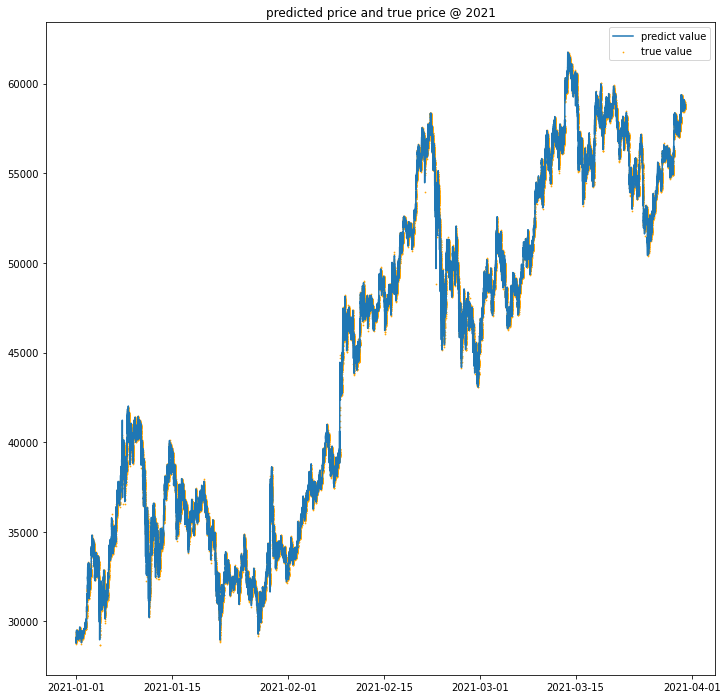

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(test_df_t.index, test_df_t.price, label="true value", s= 0.5, color = 'orange')
ax.plot(test_df_t.index, test_df_t.price_hat, label="predict value")
ax.legend()
ax.set_title("predicted price and true price @ 2021")
plt.show()

In [70]:
test_df_t.to_csv('drive/MyDrive/output.csv', index=False)